# Analysis of dog performance vs the course color

## Data preparation

Note, that I had to revisit data cleaning to have the course color as a separate column in the input csv file

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [39]:
df = pd.read_csv('races.csv')
df = df.dropna(subset=['course_color'])
print(df.shape)
df.head(2)

(7149, 21)


,division,when,team1,team2,time_tot,win,hurdles,name1,start_chng1,time1,...,start_chng2,time2,name3,start_chng3,time3,name4,start_chng4,time4,event,course_color
0,1,2020-01-01 10:11:57,WildRunners dreamers,WildRunners Maximini,17.01,L,25.0,Sunny,-0.24,4.21,...,0.30,4.24,Alex,0.16,4.22,Hector,0.0,4.13,Hanácké škvarek (Heroltice) 2023. április 22-23.,blue
1,1,2020-01-01 10:11:57,WildRunners Maximini,WildRunners dreamers,19.43,L,25.0,Brooke,-0.11,4.08,...,1.29,5.15,Bella,0.23,4.52,Bree,0.0,4.28,Hanácké škvarek (Heroltice) 2023. április 22-23.,red


In [46]:
df_run1 = df[['team1', 'name1', 'time1', 'course_color']]
df_run2 = df[['team1', 'name2', 'time2', 'course_color']]
df_run3 = df[['team1', 'name3', 'time3', 'course_color']]
df_run4 = df[['team1', 'name4', 'time4', 'course_color']]

col_names = ['team', 'name', 'time', 'course_color']
df_run1.columns = col_names
df_run2.columns = col_names
df_run3.columns = col_names
df_run4.columns = col_names

df_run_all = pd.concat([df_run1, df_run2, df_run3, df_run4])
df_run_all = df_run_all.dropna(subset=['time'])
print(df_run_all.shape)
df_run_all.head()

(28153, 4)


,team,name,time,course_color
0,WildRunners dreamers,Sunny,4.21,blue
1,WildRunners Maximini,Brooke,4.08,red
2,WildRunners dreamers,Sunny,4.25,blue
3,WildRunners Maximini,Brooke,4.25,red
4,WildRunners dreamers,Sunny,4.21,blue


## Taking all runs of all dogs into account, regardless of the team

The difference is ~0.01 sec, seems very little. Let's do a T-test to check the significance. The null-hypotesis is that there is no significat difference between running times on red and blue courses. Choosen alpha is 0.05

In [41]:
df_run_all.groupby('course_color').time.mean()

course_color
blue    4.403665
red     4.392977
Name: time, dtype: float64

As expected: with p = 0.34, we fail to reject the null hypothesis, meaning **there is no significant difference in the average time between the two groups**.

In [42]:
blue_times = df_run_all[df_run_all['course_color'] == 'blue']['time']
red_times = df_run_all[df_run_all['course_color'] == 'red']['time']

t_statistic, p_value = ttest_ind(blue_times, red_times)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


T-Statistic: 0.9640601244249917
P-Value: 0.33502406420155384


## Checking WRFT dogs only

Similar result as before: the difference is ~0.02 sec, seems very little, let's
do a T-test to check the significance:

In [43]:
df_run_all[df_run_all.team.str.startswith('Wild')].groupby('course_color').time.mean()

course_color
blue    4.505519
red     4.523343
Name: time, dtype: float64

With p = 0.66, we fail to reject the null hypothesis, meaning **there is no significant difference in the average time between the two groups.**

In [44]:
blue_times = df_run_all[df_run_all.team.str.startswith('Wild') & (df_run_all['course_color'] == 'blue')]['time']
red_times  = df_run_all[df_run_all.team.str.startswith('Wild') & (df_run_all['course_color'] == 'red')]['time']

t_statistic, p_value = ttest_ind(blue_times, red_times)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.44589945821725824
P-Value: 0.6556931349934364


## What if we check a few individual dogs?

Let's see the 9 dogs running the most one by one. 
Here I removed the outliers. In some cases we had running times over 60 sec, 
resulting and extra large std of the sample.

We fail to reject the null-hypothesis also for the selected individual dogs, so 
we can conclude that **there is no significant difference in the run time related to the course color**



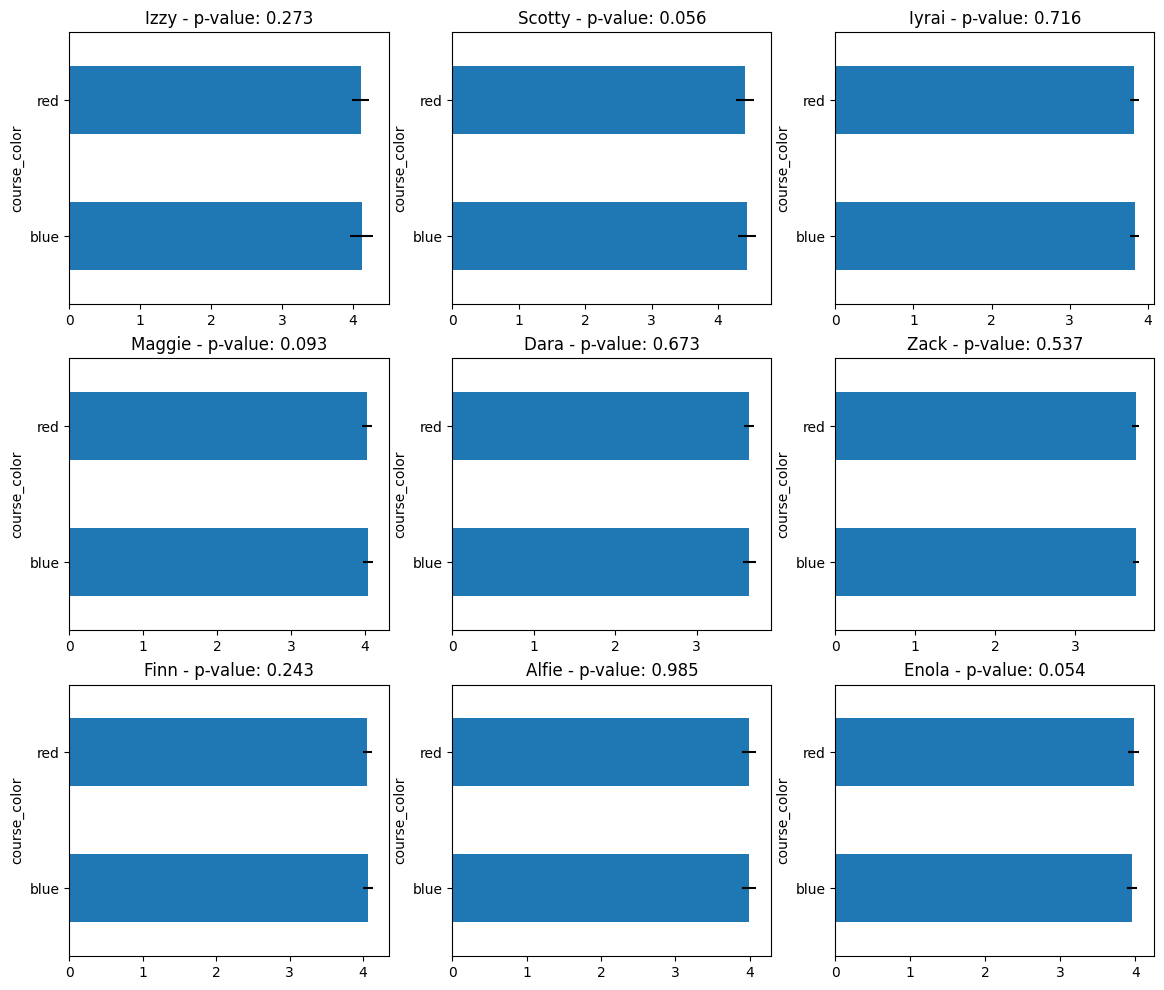

In [45]:
dogs = df_run_all.name.value_counts().index[:9]

fig, axs = plt.subplots(3, 3, figsize=(14, 12))

for i, dog in enumerate(dogs):
    runs = df_run_all[df_run_all.name == dog]

    Q1 = runs.time.quantile(0.25)
    Q3 = runs.time.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    runs = runs[(runs.time > lower_bound) & (runs.time < upper_bound)]

    blue, red = runs.groupby('course_color').time.mean()
    blue_std, red_std = runs.groupby('course_color').time.std()
    runs.groupby('course_color').time.mean().plot(kind='barh', xerr=runs.groupby('course_color').time.std(), ax=axs[i//3, i%3])

    blue_times = runs[runs['course_color'] == 'blue']['time']
    red_times = runs[runs['course_color'] == 'red']['time']
    t_statistic, p_value = ttest_ind(blue_times, red_times)
    axs[i//3, i%3].set_title(f'{dog} - p-value: {p_value:.3f}')

plt.show()